# Homework 2 - Programming Section Notebook

## Context

Given a dataset of 303 patients showcasing different medical metrics related to heart disease diagnostic, we must create a predictor for this diagnosis (target = 0 means no heart disease, whereas target = 1 means the a heart disease is present)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset_file_path = "heart-disease.csv"

data_df = pd.read_csv(dataset_file_path)

X = data_df.drop("target", axis=1)
y = data_df["target"]

## 1) Compare kNN and naive Bayes

### a) Accuracy with no scaling before training

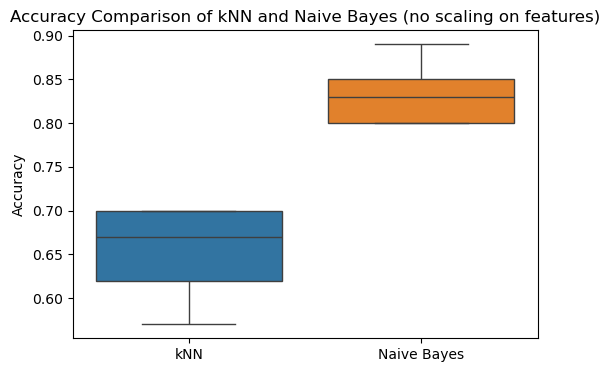

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

n_splits = 5 
n_neighbors = 5

folds = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=0)

accuracy_kNN = []
accuracy_Bayes = []

for train_id, test_id in folds.split(X,y):

    #Extract Sample feature's matrix
    X_train = X.iloc[train_id]
    X_test = X.iloc[test_id]

    #Extract Sample's target matrix
    y_train = y.iloc[train_id]
    y_test = y.iloc[test_id]

    predictor_kNN = KNeighborsClassifier(n_neighbors=n_neighbors)
    predictor_kNN.fit(X_train, y_train)

    predictor_Bayes = GaussianNB()
    predictor_Bayes.fit(X_train,y_train)

    # Make prediction on testing sample for kNN
    y_pred_test_kNN = predictor_kNN.predict(X_test)
    accuracy_kNN.append(round(accuracy_score(y_test,y_pred_test_kNN), 2))

    # Make prediction on testing sample for naive Bayes
    y_pred_test_Bayes = predictor_Bayes.predict(X_test)
    accuracy_Bayes.append(round(accuracy_score(y_test, y_pred_test_Bayes), 2))

results_df = pd.DataFrame({
    'kNN': accuracy_kNN,
    'Naive Bayes': accuracy_Bayes
})

plt.figure(figsize=(6, 4))
sns.boxplot(data=results_df)
plt.title('Accuracy Comparison of kNN and Naive Bayes (no scaling on features)')
plt.ylabel('Accuracy')
plt.show()

### b) Accuracy with Min-Max scaler before training
Makes distant neighbours take less relevancy than close neighbours, scaling accordingly.

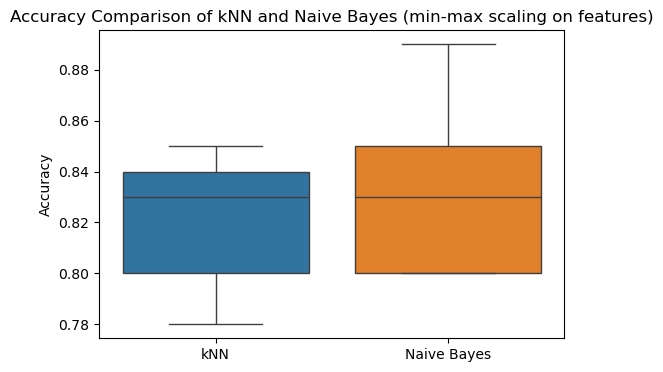

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X, y), columns=X.columns) #Converted into pd df so the rest of the program can be mostly unchanged

n_splits = 5 
n_neighbors = 5

folds = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=0)

accuracy_kNN_scaling = []
accuracy_Bayes_scaling = []

for train_id, test_id in folds.split(X_scaled,y):

    #Extract Sample feature's matrix
    X_train = X_scaled.iloc[train_id]
    X_test = X_scaled.iloc[test_id]

    #Extract Sample's target matrix
    y_train = y.iloc[train_id]
    y_test = y.iloc[test_id]

    predictor_kNN = KNeighborsClassifier(n_neighbors=n_neighbors)
    predictor_kNN.fit(X_train, y_train)

    predictor_Bayes = GaussianNB()
    predictor_Bayes.fit(X_train,y_train)

    # Make prediction on testing sample for kNN
    y_pred_test_kNN = predictor_kNN.predict(X_test)
    accuracy_kNN_scaling.append(round(accuracy_score(y_test,y_pred_test_kNN), 2))

    # Make prediction on testing sample for naive Bayes
    y_pred_test_Bayes = predictor_Bayes.predict(X_test)
    accuracy_Bayes_scaling.append(round(accuracy_score(y_test, y_pred_test_Bayes), 2))

results_df_scaling = pd.DataFrame({
    'kNN': accuracy_kNN_scaling,
    'Naive Bayes': accuracy_Bayes_scaling
})

plt.figure(figsize=(6, 4))
sns.boxplot(data=results_df_scaling)
plt.title('Accuracy Comparison of kNN and Naive Bayes (min-max scaling on features)')
plt.ylabel('Accuracy')
plt.show()

### c) Test hypthosesis “the 𝑘𝑁𝑁 model is statistically superior to naïve Bayes regarding accuracy”

We will test the hypthosesis for both the feature-scaled and non-scaled versions

In [32]:
from scipy.stats import ttest_rel

# H0: both distributions have identical accuracy
# H1: kNN is statistically superior than Bayes in terms of accuracy

result_no_scale = ttest_rel(accuracy_kNN,accuracy_Bayes, alternative="greater")
results_scale = ttest_rel(accuracy_kNN_scaling,accuracy_Bayes_scaling,alternative="greater")

p_value_no_scale = result_no_scale.pvalue
print("No scale P-value: " + str(p_value_no_scale))
print("For the accuracies obtained when not scaling feature data:")
treshholds = (0.01, 0.05, 0.1)

for threshold in treshholds:
    if p_value_no_scale <= threshold:
        print("\t- Considering a " + str(int(threshold*100)) + "% threshold, kNN is statistically superior than Bayes")
    else:
        print("\t- Considering a " + str(int(threshold*100)) + "% threshold, kNN is not statistically superior than Bayes")

p_value_scale = results_scale.pvalue
print("\nScale P-value: " + str(p_value_scale))
print("For the accuracies obtained when min-max scaling feature data:")
for threshold in treshholds:
    if p_value_no_scale <= threshold:
        print("\t- Considering a " + str(int(threshold*100)) + "% threshold, kNN is statistically superior than Bayes")
    else:
        print("\t- Considering a " + str(int(threshold*100)) + "% threshold, kNN is not statistically superior than Bayes")


No scale P-value: 0.998415501126768
For the accuracies obtained when not scaling feature data:
	- Considering a 1% threshold, kNN is not statistically superior than Bayes
	- Considering a 5% threshold, kNN is not statistically superior than Bayes
	- Considering a 10% threshold, kNN is not statistically superior than Bayes

Scale P-value: 0.7532332545792753
For the accuracies obtained when min-max scaling feature data:
	- Considering a 1% threshold, kNN is not statistically superior than Bayes
	- Considering a 5% threshold, kNN is not statistically superior than Bayes
	- Considering a 10% threshold, kNN is not statistically superior than Bayes


## 2) Test kNN classifiers with different amount of k

### a) Train and Test accuracy for each k = {1, 5, 10, 20, 30}

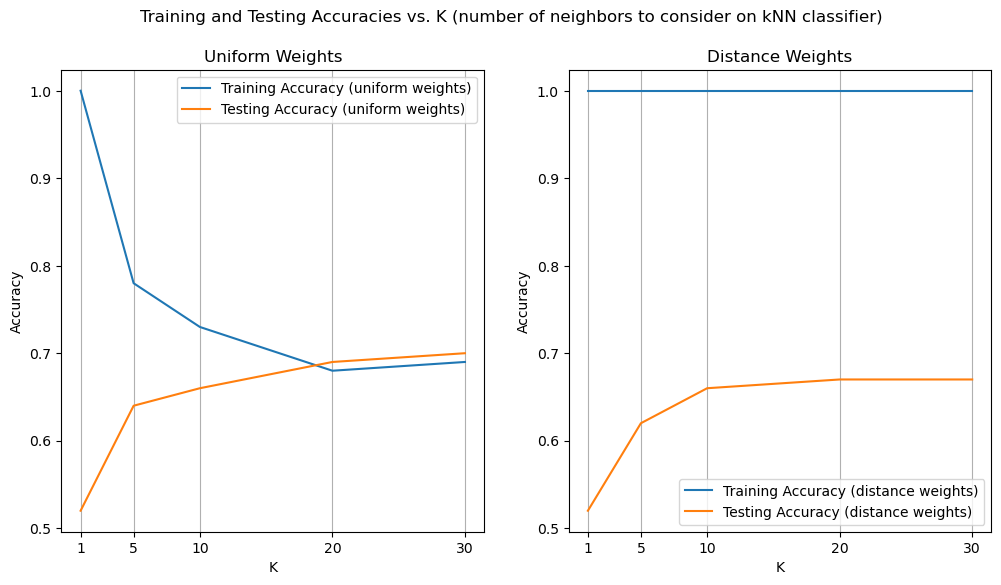

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

number_of_neighbours = [1,5,10,20,30]

training_accuracies_uniform = []
testing_accuracies_uniform = []

training_accuracies_distance = []
testing_accuracies_distance = []

for k in number_of_neighbours:

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

    #Create kNN classifier according to sample training data, with uniform weights
    predictor_uniform = KNeighborsClassifier(n_neighbors=k)
    predictor_uniform.fit(X_train,y_train)

    #Generate prediction according to test sample and measure accuracy
    y_pred_test = predictor_uniform.predict(X_test)
    testing_accuracies_uniform.append(round(accuracy_score(y_test, y_pred_test),2))

    #Generate prediction according to training sample and measure accuracy
    y_pred_train = predictor_uniform.predict(X_train)
    training_accuracies_uniform.append(round(accuracy_score(y_train, y_pred_train),2))

    #Create kNN classifier according to sample training data, with distance-based weights

    predictor_distance = KNeighborsClassifier(n_neighbors=k,weights="distance")

    predictor_distance.fit(X_train,y_train)

    #Generate prediction according to test sample and measure accuracy
    y_pred_test = predictor_distance.predict(X_test)
    testing_accuracies_distance.append(round(accuracy_score(y_test, y_pred_test),2))

    #Generate prediction according to training sample and measure accuracy
    y_pred_train = predictor_distance.predict(X_train)
    training_accuracies_distance.append(round(accuracy_score(y_train, y_pred_train),2))

accuracy_df = pd.DataFrame({
    'k': number_of_neighbours,
    'training_accuracies_uniform': training_accuracies_uniform,
    'testing_accuracies_uniform': testing_accuracies_uniform,
    'training_accuracies_distance': training_accuracies_distance,
    'testing_accuracies_testing': testing_accuracies_distance
})

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(ax=axes[0], data=accuracy_df, x="k", y="training_accuracies_uniform", label="Training Accuracy (uniform weights)")
sns.lineplot(ax=axes[0], data=accuracy_df, x="k", y="testing_accuracies_uniform", label="Testing Accuracy (uniform weights)")
axes[0].set_title("Uniform Weights")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].set_xticks(number_of_neighbours)
axes[0].grid(True, which='both', axis='x')

sns.lineplot(ax=axes[1], data=accuracy_df, x="k", y="training_accuracies_distance", label="Training Accuracy (distance weights)")
sns.lineplot(ax=axes[1], data=accuracy_df, x="k", y="testing_accuracies_testing", label="Testing Accuracy (distance weights)")
axes[1].set_title("Distance Weights")
axes[1].set_xlabel("K")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].set_xticks(number_of_neighbours)
axes[1].grid(True, which='both', axis='x')

plt.suptitle("Training and Testing Accuracies vs. K (number of neighbors to consider on kNN classifier)")
plt.show()